### Intente hacer un agente que pueda pedir mas docs, lo hice malardo XD


In [ ]:
#segmentacion de docs
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

#Vector store

from langchain_community.vectorstores import SQLiteVec

# llms
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

#Langgraph modules
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool

# python common modules
from IPython.display import Image, display
from typing_extensions import List
from typing import Literal
from dotenv import load_dotenv
from pathlib import Path

import os

load_dotenv()

base_dir = Path.cwd()
leyes_dir = base_dir / "leyes"  # Adjust this path based on your actual directory structure

# If leyes_dir doesn't exist, try going up one level
if not leyes_dir.exists():
    leyes_dir = base_dir.parent / "leyes"
    
retrieve_limit = 1

openai_api_key = os.getenv("DEEPSEEK_API_KEY")
openai_base_url = os.getenv("DEEPSEEK_API_URL")
openai_model = os.getenv("LLM_MODEL")

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(
    # base_url=openai_base_url,
    # api_key=openai_api_key,
    model= openai_model,
    temperature=0.5, 
    
)
print(llm)

client=<openai.resources.chat.completions.completions.Completions object at 0x0000017F79F2DD30> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000017F79F3E510> root_client=<openai.OpenAI object at 0x0000017F79D13770> root_async_client=<openai.AsyncOpenAI object at 0x0000017F79F2DE80> model_name='gpt-4o-mini' temperature=0.5 model_kwargs={} openai_api_key=SecretStr('**********')


Definir base de datos

In [2]:
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2") 

embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002",
)   

Herramienta Recuperadora de docs

In [ ]:
numero_docs_recuperados: int  = 4

@tool(response_format="content_and_artifact")
def recuperarDocs(query: str):
    """Retrieve information related to a query."""
    try:
        db_path_str = str(base_dir / "Database/leyes recursive.db")

        vector_store = SQLiteVec(
        table="leyes",
        connection=None,
        embedding=embeddings,
        db_file=db_path_str,
        )   
        
        retrieved_docs = vector_store.similarity_search(query, k=numero_docs_recuperados)
        
        # Properly access document attributes
        serialized = "\n\n".join(
            (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}" )
            for doc in retrieved_docs
        )
        return serialized, retrieved_docs
    except Exception as e:
        # Add error logging for debugging
        print(f"Error in recuperarDocs: {e}")
        print(f"Type of error: {type(e)}")
        import traceback
        traceback.print_exc()
        # Return a fallback response
        return "Error retrieving documents", []
tools = [recuperarDocs]

### Definimos el objetpo estado que será pasado entre nodos para añadir mensajes

In [4]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]
    summary: str
    rewrite_count: int = 0

### Definimos el Edge condicional (arista entre los grafos) para ver si los documentos son suficientes o se necesita rewrite la pregunta

In [5]:

from typing import  Literal
from langchain import hub
from langchain_core.messages import  HumanMessage, RemoveMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition

### Edges
rewrite_limit = 1
max_messages_before_summarize = 5

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")
    
    rewrite_count = state.get("rewrite_count", 0)
    if  rewrite_count >= rewrite_limit:
        print(f"---LÍMITE DE REFORMULACIONES ALCANZADO ({rewrite_count}/{rewrite_limit})---")
        return "generate"

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model=openai_model, streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""Eres un evaluador que determina la relevancia de un documento recuperado para una pregunta del usuario. \n 
        Aquí está el documento recuperado: \n\n {context} \n\n
        Aquí está la pregunta del usuario: {question} \n
        Si el documento contiene palabra(s) clave o significado semántico relacionado con la pregunta del usuario Y podría resolverla, califícalo como relevante. \n
        Da una puntuación binaria 'sí' o 'no' para indicar si el documento es relevante para la pregunta.""",
        input_variables=["context", "question"],
        )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score
    

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print(f"---DECISION: DOCS NO RELEVANTES (Intento {rewrite_count+1}/{rewrite_limit})---")
        print(score)
        return "rewrite"
    

def should_continue(state) -> Literal["summarize_conversation", "agent"]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > max_messages_before_summarize:
        print(f"---LIMITE DE MENSAJES ALCANZADO ({len(messages)}/{max_messages_before_summarize})---")
        return "summarize_conversation"
    
    # Otherwise we can just end
    return "agent"


### Nodes
import json
from pathlib import Path

def pre_rewrite(state):
    """
    Pre-processing step to transform the query before retrieval.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """
    print("---PRE-REWRITE---")
    
    reset_rewrite_count = 0
    state["rewrite_count"] = reset_rewrite_count
    
    messages = state["messages"]
    question = messages[0].content

    # Load the synonyms from the JSON file
    with open(Path.cwd() / "categorias_sinonimos_bolivia.json", "r", encoding="utf-8") as f:
        synonyms = json.load(f)
    print(synonyms)

    # Create a mapping of colloquial terms to standardized terms
    colloquial_to_standard = {}
    for category, terms in synonyms.items():
        standard_term = category.split(" / ")[0].lower()  # Use the category name as the standard term
        for term in terms:
            colloquial_to_standard[term.lower()] = standard_term

    # Replace colloquialisms in the question
    import re

    words = re.findall(r'\b\w+\b', question)
    standardized_words = [
        colloquial_to_standard.get(word.lower(), word) for word in words
    ]
    standardized_question = " ".join(standardized_words)

    print(f"Original question: {question}")
    print(f"Standardized question: {standardized_question}")

    # Update the state with the standardized question
    return {"messages": [HumanMessage(content=standardized_question)]}

def summarize_conversation(state):
    """
    Summarize the conversation so far to provide context for the agent.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the summary appended to messages
    """
    print("---SUMMARIZE---")
    
     # First, we get any existing summary
    summary = state.get("summary", "")
    if summary:
        # A summary already exists
        summary_message = (
            f"Este es el resumen de la conversacion hasta ahora {summary}\n\n"
            "Extiende el resumen tomando en cuenta los mensajes anteriores:"
        )
    else:
        summary_message = "Crea un resumen de la conversacion en 3 breves oraciones:"
    
    messages = state["messages"] + [SystemMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}
    

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    last_message = messages[-1]

    summary = state.get("summary", "")

    if summary:
        sys_msg=f"""
            Eres un asistente legal que responde preguntas sobre el reglamento de tránsito boliviano.\n\n
            Aquí está el resumen de la conversación hasta ahora: \n\n {summary} \n\n
            si necesitas usa la herramienta de recuperacion de informacion, haz el query con menor cantidad de tokens y no menciones a bolivia.
        """
    else:
        sys_msg="""
            Eres un asistente legal que responde preguntas sobre el reglamento de tránsito boliviano. \n\n
            si necesitas usa la herramienta de recuperacion de informacion, haz el query con menor cantidad de tokens y no menciones a bolivia.
        """
        
    # System message
    system_message = SystemMessage(content=sys_msg)
    model = ChatOpenAI(temperature=0, streaming=True, model=openai_model)
    model = model.bind_tools(tools)
    
    response = model.invoke([system_message, last_message])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        SystemMessage(content=f""" \n 
        Observa la entrada e intenta razonar sobre la intención / significado semántico subyacente. \n 
        Aquí está la pregunta inicial:
        \n ------- \n
        {question} 
        \n ------- \n
        Formula una breve pregunta mejorada: """,
            )
        ]

    # Increment the rewrite counter
    new_count = state.get("rewrite_count", 0) + 1
    
    # Grader
    model = ChatOpenAI(temperature=0, model=openai_model, streaming=True)
    response = model.invoke(msg)
    return {"messages": [response], "rewrite_count": new_count}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[1].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name=openai_model, temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

Grafo

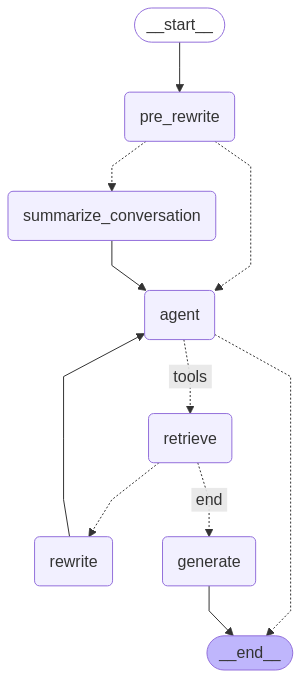

In [6]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("pre_rewrite", pre_rewrite)  # Start node
workflow.add_node("summarize_conversation", summarize_conversation)  # Summarization node
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([recuperarDocs])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "pre_rewrite")
workflow.add_conditional_edges(
    "pre_rewrite", 
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "agent": "agent"
    }
)
workflow.add_edge( "summarize_conversation", "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate": "generate",
        "rewrite": "rewrite",
        "end": "generate"  # If we hit the limit, go to generate anyway
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

funcion para reemplazar terminos bolivianos

In [7]:
from langchain_core.messages import  HumanMessage

config = {"configurable": {"thread_id": "1"}}

# Comenzar conversacion
messages = [
    HumanMessage(content="¿Que pasa si atropello a alguien?"),
]
output_messages = graph.invoke({"messages": messages}, config)
for m in output_messages['messages']:
    m.pretty_print()
    
    
# Comenzar conversacion
messages = [
    HumanMessage(content="¿y si escapo?"),
]
output_messages = graph.invoke({"messages": messages}, config)
for m in output_messages['messages']:
    m.pretty_print()

---PRE-REWRITE---
{'Policía / Tránsito': ['paco', 'policia', 'tránsito', 'oficial', 'agente de tránsito', 'operativo', 'patrullero', 'control', 'control de tránsito', 'control vehicular', 'control de vehículos', 'control de tránsito vehicular', 'control de tránsito automotor', 'control de tránsito terrestre'], 'Licencias': ['licencia', 'brevete', 'breve', 'brevet', 'permiso de conducir', 'carnet de conducir', 'licencia de conducir', 'duplicado', 'categoría a', 'categoría b', 'categoría c', 'categoria T', 'categoria P', 'categoria P (particular)', 'profesional A', 'profesional B', 'profesional C', 'profesional C indefinida', 'profesional T', 'licencia categoria A', 'licencia categoria B', 'licencia categoria C', 'licencia categoria T', 'licencia categoria P', 'licencia categoria P (particular)', 'licencia profesional A', 'licencia profesional B', 'licencia profesional C', 'licencia profesional C indefinida', 'licencia profesional T', 'licencia de conducir categoria A', 'licencia de cond

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************9VkA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}